# Transient elastodynamics with Newmark time-integration {far}`star`{far}`star`

```{admonition} Objectives
:class: objectives

This demo shows how to perform time integration of transient dynamics in the linear elastic case using the Newmark scheme.$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\ba}{\boldsymbol{a}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bf}{\boldsymbol{f}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}$
```

```{image} beam.gif
:width: 600px
:align: center
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./elastodynamics_newmark.py>`
* {Download}`Jupyter notebook<./elastodynamics_newmark.ipynb>`
```

## Introduction and elastodynamics equation

The elastodynamics equation combine the balance of linear momentum:

$$
\nabla \cdot \bsig + \rho \bf = \rho \ddot{\bu}
$$

where $\bu$ is the displacement vector field, $\ba=\ddot{\bu}=\dfrac{\partial^2 \bu}{\partial t^2}$ is the acceleration,
$\rho$ the material density, $\bf$ a given body force and $\bsig$ the stress tensor which is related
to the displacement through a constitutive equation. We consider in the following the case of isotropic linear elasticity.

The weak form is readily obtained by integrating by part the balance equation using a test function $\bv\in V$
with $V$ being a suitable function space that satisfies the displacement boundary conditions:

$$
\int_{\Omega} \rho \ddot{\bu}\cdot \bv \dOm + \int_{\Omega} \bsig(\bu):\beps(v) \dOm = \int_{\Omega} \rho \bf \cdot \bv \dOm + \int_{\partial\Omega} (\bsig\bn) \cdot \bv \dS \quad \text{for all } \bv\in V
$$

The previous equation can be written as follows:

$$
\text{Find }\bu\in V\text{ such that } m(\ddot{\bu},\bv) + k(\bu,\bv) = L(\bv) \quad \text{for all } \bv\in V
$$

where $m$ is the symmetric bilinear form associated with the mass matrix and $k$ the one associated with the stiffness matrix.

After introducing the finite element space interpolation, one obtains the corresponding discretized evolution equation:

$$
\text{Find }\{u\}\in\mathbb{R}^n\text{ such that } \{v\}^T[M]\{\ddot{u}\} + \{v\}^T[K]\{u\} = \{v\}^T\{F\} \quad \text{for all } \{v\}\in\mathbb{R}^n
$$

which is a generalized $n$-dof harmonic oscillator equation.

## Adding dissipation

Quite often in structural dynamics, structures do not oscillate perfectly but lose energy through various dissipative mechanisms (friction with air or supports, internal dissipation through plasticity, damage, etc.). Dissipative terms can be introduced at the level of the constitutive equation if these mechanisms are well
known but quite often it is not the case. Dissipation can then be modeled by adding an *ad hoc* damping term depending on the structure velocity $\dot{\bu}$ to the previous evolution equation:

$$
\text{Find }\bu\in V\text{ such that } m(\ddot{\bu},\bv) + c(\dot{\bu},\bv) + k(\bu,\bv) = L(\bv) \quad \text{for all } \bv\in V
$$

The damping form $c$ is generally considered to be bilinear and symmetric, being therefore associated with a symmetric damping matrix $[C]$.

### Rayleigh damping

When little is known about the origin of damping in the structure, a popular choice for the damping matrix, known as *Rayleigh damping*, consists in using a linear combination of the mass and stiffness matrix $[C] = \eta_M[M]+\eta_K[K]$ with two positive parameters $\eta_M,\eta_K$ which can be fitted against experimental data for instance (usually by measuring the damping ratio of two natural modes of vibration).

One notable advantage of using such a choice is that modes identified from the modal analysis based on $[K]$ and $[M]$ still form an orthogonal basis, yielding decoupled evolution equations, even in the presence of damping. This is no longer the case in general for other forms of damping modeling.

## Time discretization using the Newmark scheme

We now introduce a time discretization of the interval study $[0;T]$ in $N+1$ time increments $t_0=0,t_1,\ldots,t_N,t_{N+1}=T$
with $\Delta t=T/N$ denoting the time step (supposed constant). The resolution will make use of the Newmark-$\beta$ method {cite:p}`newmark1959method` in structural dynamics. As an implicit method, it is unconditionally stable for a proper choice of coefficients so that quite large time steps can be used.

The method consists in solving the dynamic evolution equation at intermediate time between $t_n$ and $t_{n+1}$ as follows:

```{math}
:label: discrete-elastodynamics

[M]\{\ddot{u}_{n+1}\} + [C]\{\dot{u}_{n+1}\}+[K]\{u_{n+1}\} = \{F(t_{n+1})\}
```

In addition, the following approximation for the displacement and velocity
at $t_{n+1}$ are used:

```{math}
:label: displ-update

\{u_{n+1}\} = \{u_{n}\}+\Delta t \{\dot{u}_{n}\} + \dfrac{\Delta t^2}{2}\left((1-2\beta)\{\ddot{u}_{n}\}+2\beta\{\ddot{u}_{n+1}\}\right)
```

```{math}
:label: velocity-update

\{\dot{u}_{n+1}\} = \{\dot{u}_{n}\} + \Delta t\left((1-\gamma)\{\ddot{u}_{n}\}+\gamma\{\ddot{u}_{n+1}\}\right)
```
where the parameters $\gamma\in[0;1]$ and $\beta\in[0;1/2]$ determine the stability and accuracy of the approximation.

We can use the previous expressions to express the acceleration $\ddot{u}_{n+1}$ in terms of unknown displacement at $t_{n+1}$ with:

```{math}
:label: acceleration-formula

\{\ddot{u}_{n+1}\} = \dfrac{1}{\beta\Delta t^2}\left(\{u_{n+1}\} - \{u_{n}\}-\Delta t \{\dot{u}_{n}\} \right) - \dfrac{1-2\beta}{2\beta}\{\ddot{u}_{n}\}
```


### Popular choice of parameters

The most popular choice for the parameters is: $\gamma=\dfrac{1}{2}$,
$\beta=\dfrac{1}{4}$ which ensures unconditional stability, energy conservation and second-order accuracy.


## Implementation

We first import the relevant packages for this demo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output

from mpi4py import MPI
import ufl
from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.mesh import create_box, CellType

We consider a slender beam of length `L` with a rectangular cross-section of width `B` and height `H`. We create a corresponding hexahedral mesh. We will discretize in space using $\mathbb{P}_2$ hexahedral elements. Note that $\mathbb{P}_1$ hexahedral elements suffer from severe shear-locking issues in such situation, needing specific treatment such as selective reduced integration to yield correct result. The mesh resolution is chosen to be quite coarse to limit the computational cost when running the demo.

In [2]:
L = 8.0
H = 0.2
B = 0.1
domain = create_box(
    MPI.COMM_WORLD,
    [[0.0, -B / 2, -H / 2], [L, B / 2, H / 2]],
    [8, 2, 2],
    CellType.hexahedron,
)

dim = domain.topology.dim
dx = ufl.Measure("dx", domain=domain)

degree = 2
shape = (dim,)
V = fem.functionspace(domain, ("Q", degree, shape))

u = fem.Function(V, name="Displacement")

Boundary conditions will consist of the left extremity of the beam being fully clamped. We also retrieve the dof corresponding to the center of the cross-section located at the right extremity (`point(x)`) to monitor its displacement during the simulation.

```{attention}
`fem.locate_dofs_geometrical` returns the `dof` index of the point in the `dofmap`. However, each `dof` has a block size which corresponds here to the shape of the vector function space `V`, namely 3 in the present case. The dof indices of the $x$, $y$ and $z$ components of this point are therefore given by `point_dofs = np.arange(point_dof * dim, (point_dof + 1) * dim)`.

In general, the dof block size can be obtained from `V.dofmap.index_map_bs`.
```

In [3]:
def left(x):
    return np.isclose(x[0], 0.0)


def point(x):
    return np.isclose(x[0], L) & np.isclose(x[1], 0) & np.isclose(x[2], 0)


clamped_dofs = fem.locate_dofs_geometrical(V, left)
point_dof = fem.locate_dofs_geometrical(V, point)[0]
point_dofs = np.arange(point_dof * dim, (point_dof + 1) * dim)


bcs = [fem.dirichletbc(np.zeros((dim,)), clamped_dofs, V)]

We now define the material elastic properties and the linear elastic constitutive relation, see [](/tours/linear_problems/isotropic_orthotropic_elasticity/isotropic_orthotropic_elasticity.md) for more details.

In [4]:
E = fem.Constant(domain, 210e3)
nu = fem.Constant(domain, 0.3)
rho = fem.Constant(domain, 7.8e-3)
f = fem.Constant(domain, (0.0,) * dim)

lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)


def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

We are now ready to implement the Newmark time discretization of the elastodynamics equation {eq}`discrete-elastodynamics`. We first define functions `u_old`, `v_old` and `a_old` which will be used to store the displacement, velocity and acceleration at the previous time step $t_n$. We will also need two functions to store the acceleration `a_new` and the velocity `v_new` at the current time step $t_{n+1}$. We define the Newmark $\beta$ and $\gamma$ parameters, which are selected at the usual $\beta=0.25$ and $\gamma=0.5$ values. Finally, we define the UFL expressions `a` and `v` corresponding to relation {eq}`acceleration-formula` and {eq}`velocity-update` which express the new acceleration and velocity as a function of the unknown displacement `u` and the fields at the previous time step. These UFL expressions will then be used in the variational form.

In [5]:
u_old = fem.Function(V)
v_old = fem.Function(V)
a_old = fem.Function(V)
a_new = fem.Function(V)
v_new = fem.Function(V)

beta_ = 0.25
beta = fem.Constant(domain, beta_)
gamma_ = 0.5
gamma = fem.Constant(domain, gamma_)
dt = fem.Constant(domain, 0.0)

a = 1 / beta / dt**2 * (u - u_old - dt * v_old) + a_old * (1 - 1 / 2 / beta)
a_expr = fem.Expression(a, V.element.interpolation_points())

v = v_old + dt * ((1 - gamma) * a_old + gamma * a)
v_expr = fem.Expression(v, V.element.interpolation_points())

Now, we define a mass, a stiffness and a damping form which are used to define `Residual` as the residual weak form of the elastodynamics equation {eq}`discrete-elastodynamics`. In the present case, the latter is in fact a linear form of the unknown `u`. We therefore replace every instance of `u` with a trial function `du` to obtain a combined bilinear and linear form and extract the relevant bilinear part using `ufl.lhs` and the corresponding linear right-hand side using `ufl.rhs`. We can then setup the corresponding `LinearProblem` object.

```{tip}
It is recommended to define all the forms and objects such as `LinearProblem` outside the time-stepping loop. This avoids creating at each time step a new object which instantiates PETSc matrices, solvers, etc. under the hood. This approach requires to update values of the external loading or boundary conditions without recreating new objects.
```

In [6]:
u_ = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

eta_M = fem.Constant(domain, 1e-4)
eta_K = fem.Constant(domain, 1e-4)


def mass(u, u_):
    return rho * ufl.dot(u, u_) * ufl.dx


def stiffness(u, u_):
    return ufl.inner(sigma(u), epsilon(u_)) * ufl.dx


def damping(u, u_):
    return eta_M * mass(u, u_) + eta_K * stiffness(u, u_)


Residual = mass(a, u_) + damping(v, u_) + stiffness(u, u_) - ufl.dot(f, u_) * ufl.dx

Residual_du = ufl.replace(Residual, {u: du})
a_form = ufl.lhs(Residual_du)
L_form = ufl.rhs(Residual_du)

problem = fem.petsc.LinearProblem(
    a_form, L_form, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)

We also define the forms corresponding to the total kinetic `E_kin` and elastic `E_el` energies as well as the damping dissipated power `P_damp`. Indeed, multiplying equation {eq}`discrete-elastodynamics` with $\{\dot{u}\}$ yields:

$$
\dfrac{\text{d}}{\text{d}t}\left(\mathcal{E}_\text{kin} +\mathcal{E}_\text{el}\right) + \mathcal{P}_\text{damp} =  \mathcal{P}_\text{ext}
$$
where:

$$
\begin{align*}
\mathcal{E}_\text{kin} &= \dfrac{1}{2}\{\dot{u}\}[M]\{\dot{u}\}\\
\mathcal{E}_\text{el} &= \dfrac{1}{2}\{u\}[K]\{u\}\\
\mathcal{P}_\text{damp} &= \{\dot{u}\}[C]\{\dot{u}\}\\
\end{align*}
$$

Thus, in the absence of external forcing ($\mathcal{P}_\text{ext}=0$), we see that the sum of all three contributions of kinetic, elastic and damping energies are conserved:

$$
\mathcal{E}_\text{kin} +\mathcal{E}_\text{el} + \int_0^T \mathcal{P}_\text{damp} \text{d}t = \text{cst}
$$

We compute all three contributions to check the conservation of total energy by the Newmark scheme.

In [7]:
E_kin = fem.form(0.5 * mass(v_old, v_old))
E_el = fem.form(0.5 * stiffness(u_old, u_old))
P_damp = fem.form(damping(v_old, v_old))

Finally, we implement the time stepping loop over `Nsteps` time increments of size `dt`, which can possibly vary with time. Fields output are saved in a `VTKFile`. We choose here to save only `Nsave=100` snapshots in total, thus outputting to the file only every `save_freq` time steps.

The loading consists of a uniform body force acting in the $(y,z)$ plane which is linearly applied from 0 to its maximum value for a short time period of 0.2s. Then the loading is removed and the beam oscillates freely. Once the elastodynamics system has been solved with the call to `problem.solve()`, the field `u` now contains the displacement $\{u_{n+1}\}$. We can then compute the nodal values of the acceleration $\{\ddot{u}_{n+1}\}$ using {eq}`acceleration-formula` and the velocity $\{\dot{u}_{n+1}\}$ using {eq}`velocity-update`. We then march forward in time by replacing the fields at the previous time step with the new values. Finally, we compute the kinetic and elastic energies and the damping dissipation by accumulating $\Delta t \mathcal{P}_\text{damp}$ at each time step. We also store the in-plane displacements $u_y,u_z$ of the right extremity.

```{note}
We have chosen here to use the interpolation mechanism of the UFL expressions `a` and `v` via a `fem.Expression` which we interpolate at the interpolation points of the function space `V`. We could also have computed directly formula {eq}`acceleration-formula` and {eq}`velocity-update` by working with the array of values, as done below for the velocity update. Here, we make use of the fact that we have already implemented such formulae when defining the variational form which avoids reimplementing these formulae a second time.
```

In [8]:
vtk = io.VTKFile(domain.comm, "results/elastodynamics.pvd", "w")

t = 0.0

Nsteps = 400
Nsave = 100
times = np.linspace(0, 2, Nsteps + 1)
save_freq = Nsteps // Nsave
energies = np.zeros((Nsteps + 1, 3))
tip_displacement = np.zeros((Nsteps + 1, 3))
for i, dti in enumerate(np.diff(times)):
    if i % save_freq == 0:
        vtk.write_function(u, t)

    dt.value = dti
    t += dti

    if t <= 0.2:
        f.value = np.array([0.0, 1.0, 1.5]) * t / 0.2
    else:
        f.value *= 0.0

    problem.solve()

    u.x.scatter_forward()  # updates ghost values for parallel computations

    # compute new velocity v_n+1
    v_new.interpolate(v_expr)

    # compute new acceleration a_n+1
    a_new.interpolate(a_expr)

    # update u_n with u_n+1
    u.vector.copy(u_old.vector)

    # update v_n with v_n+1
    v_new.vector.copy(v_old.vector)

    # update a_n with a_n+1
    a_new.vector.copy(a_old.vector)

    energies[i + 1, 0] = fem.assemble_scalar(E_el)
    energies[i + 1, 1] = fem.assemble_scalar(E_kin)
    energies[i + 1, 2] = energies[i, 2] + dti * fem.assemble_scalar(P_damp)

    tip_displacement[i + 1, :] = u.x.array[point_dofs]

    clear_output(wait=True)
    print(f"Time increment {i+1}/{Nsteps}")

vtk.close()

Time increment 400/400


## Results

We animate here the displacement of the beam extremity in the $(y,z)$ plane. Due to the chosen loading, the free oscillations mainly involve the first two bending modes. Eigenfrequencies of such modes using the Euler-Bernoulli beam theory are given by:

$$
\omega_y = \alpha_1^2 \sqrt{\dfrac{EI_y}{\rho S L^4}}
$$
for the vertical bending mode oscillating around the $y$-axis, where $I_y=\dfrac{BH^3}{12}$ is the corresponding bending inertia and $S=BH$ the cross-section area. Here, $\alpha_1$ is the smallest root to the transcendental equation:

$$
\cos(\alpha)\cosh(\alpha)+1=0
$$
which is approximately $\alpha_1=1.8751$.

The eigenfrequency corresponding to the lateral oscillations around the vertical $z$-axis is similar except that the inertia is now $I_z= \dfrac{HB^3}{12}$, so that $\omega_z = \dfrac{B}{H}\omega_y$.

Assuming that only these two modes are participating to the beam general movement, the displacement of the extremity is expected to oscillate around the following periodic orbit:

```{math}
:label: periodic-orbit
\begin{align*}
u_y &= u_{0y}\sin(\omega_z t)\\
u_z &= u_{0z}\sin(\omega_y t)
\end{align*}
```
where $u_{0y}$ and $u_{0z}$ depend on the initial condition induced by the initial loading. Below, we measure the latter from the maximum recorded displacement. The black dashed line denotes the theoretical periodic orbit {eq}`periodic-orbit`.

In [9]:
cmap = plt.get_cmap("plasma")
colors = cmap(times / max(times))

I_y = B * H**3 / 12
omega_y = 1.875**2 * np.sqrt(float(E) * I_y / (float(rho) * B * H * L**4))
omega_z = omega_y * B / H
fig = plt.figure()
ax = fig.gca()
ax.set_aspect("equal")
lines = ax.plot(
    max(tip_displacement[:, 1]) * np.sin(omega_z * times),
    max(tip_displacement[:, 2]) * np.sin(omega_y * times),
    "--k",
    alpha=0.7,
)
ax.set_ylim(-2, 2)
ax.set_xlim(-3, 3)
markers = []


def draw_frame(n):
    markers.append(
        ax.plot(tip_displacement[n, 1], tip_displacement[n, 2], "o", color=colors[n])[0]
    )
    return markers


anim = animation.FuncAnimation(fig, draw_frame, frames=Nsteps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Finally, we plot the three contributions to the total energy. We see that the kinetic and elastic energy contributions decreases with time due to the slight damping dissipation induced by non-zero values for $\eta_M$ and $\eta_K$. However, we verify that the sum of all three contributions is conserved once there is no external loading anymore.

Text(0, 0.5, 'Energies')

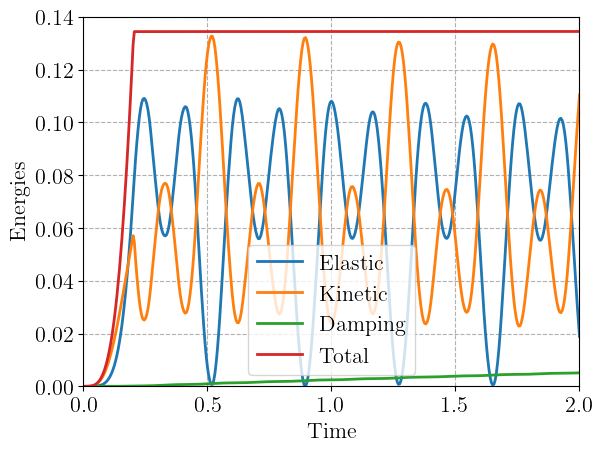

In [10]:
plt.plot(times, energies[:, 0], label="Elastic")
plt.plot(times, energies[:, 1], label="Kinetic")
plt.plot(times, energies[:, 2], label="Damping")
plt.plot(times, np.sum(energies, axis=1), label="Total")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energies")

## References

```{bibliography}
:filter: docname in docnames
```